# Airlines

### Data cleaning and airline name extraction

In [140]:
import numpy as np
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

# Read original csv file
df0 = pd.read_csv('tweets_public3.csv', encoding='utf-16', index_col='tweet_id', sep=',')
#df0.count()

# Keep relevant columns only
df1 = df0.drop(['retweet_count','is_reply','reply_count','tweet_coord','tweet_location','user_timezone'], axis=1)
df1.head()

,tweet_created,airline_sentiment,text,newairline_sentiment
tweet_id,,,,
942743012337123328,Mon Dec 18 13:07:04 +0000 2017,positive,"""Los pilotos de Ryanair desconvocan la huelga ...",positive
926857871916183553,Sat Nov 04 17:05:11 +0000 2017,positive,"@Iberia @lavecinarubia Si ,por favor las decla...",positive
936979305720090626,Sat Dec 02 15:24:09 +0000 2017,neutral,@Iberia Me dirías por favor que costo tiene?,neutral
943983853802328064,Thu Dec 21 23:17:43 +0000 2017,negative,"@SupermanlopezN @Iberia @giroditalia Champion,...",negative
938207464457211904,Wed Dec 06 00:44:25 +0000 2017,negative,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,negative


In [141]:
import unidecode #pip install unidecode
import string

def basicCleaning(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Delete URLs www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Remove accents
    tweet = unidecode.unidecode(tweet)
    #Delete via, rt and by
    tweet = re.sub(r'\b(rt|via|by)\b','',tweet)
    # Remove numbers
    tweet = re.sub(r'\d+','',tweet)
    # Remove single characters
    tweet = re.sub(r'\b\w\b','',tweet)

    #Remove additional white spaces
    tweet = re.sub('\s+', ' ', tweet)
    # Remove punctuation (includes @, \ and #)
    regex = re.compile('[%s]' % re.escape(string.punctuation+u"¡"+u"¿"+u"€"))
    tweet = re.sub(regex,'',tweet)
    return tweet

def extract_airline(tweet):
    airlinesList = ['aena','aeromar','aeromexico','aireuropa','airmadrid','airnostrum','americanairlines',
         'avianca','blueair','britishairways','easyjet','emirates','iberia','klm',
         'lufthansa','niki','norwegian','qatar','ryanair','spanair','spiritairlines',
         'tame','vasp','vueling','westjet','wizzair']
    patterns = [re.compile(r'aena'),re.compile(r'aeromar?'),
            re.compile(r'aeromexi?c?o?'),re.compile(r'air\s?europ?a?'),
            re.compile(r'airmadr?i?d?'),re.compile(r'airnostru?m?'),
            re.compile(r'american\s?air?l?i?n?e?s?'),re.compile(r'avianca'),re.compile(r'blueai?r?'),
            re.compile(r'british\s?a?i?r?w?a?y?s?'),re.compile(r'easyjet'),
            re.compile(r'emitares'),
            re.compile(r'ibe?r?i?a?'),re.compile(r'klm'),
            re.compile(r'lufthansa'),re.compile(r'niki'),re.compile(r'norwegian'),
            re.compile(r'quatara?i?r?'),re.compile(r'ryanai?r?'),
            re.compile(r'spanai?r?'),re.compile(r'spiritairl?i?n?e?s?'),
            re.compile(r'tame'),re.compile(r'vasp'),
            re.compile(r'vueling'),re.compile(r'westjet'),re.compile(r'wizza?i?r?')]
      
    noms = str()
    i = 0
    for airline in patterns:
        match = re.search(airline, tweet)
        if match : noms = noms+'|'+airlinesList[i]
        i = i + 1
    if (len(noms) == 0): 
        noms = 'noairline'
    else:
        noms = noms[1:]
    return noms


def cleaning_and_airlines(df):
    airlinesList = ['aena','aeromar','aeromexico','aireuropa','airmadrid','airnostrum','americanairlines',
         'avianca','blueair','britishairways','easyjet','emirates','iberia','klm',
         'lufthansa','niki','noairline','norwegian','qatar','ryanair','spanair','spiritairlines',
         'tame','vasp','vueling','westjet','wizzair']
    
    textClean = df['text'].apply(basicCleaning)
    airline = textClean.apply(extract_airline)

    # From 'airline' column create a one-hot encoding matrix for airline name
    tweet_airline = airline.str.split(r'|', expand=True).stack().reset_index(level='tweet_id')
    tweet_airline.columns = ['tweet_id','airline']
    tweet_airline = tweet_airline.set_index('tweet_id')
    # One-hot encoding for airline name
    onehot = pd.get_dummies(tweet_airline['airline'],columns=airlinesList)
    #print(onehot.columns)
    airlines1hot = onehot.groupby('tweet_id').sum()
    #airlines1hot.sum() #Check the list of airlines extracted
    return airlines1hot

In [142]:
# Extract airline names in tweets and create a 1 hot-encoding matrix
airlines1hot = cleaning_and_airlines(df1)
# Compute total number of citations per airline
allairlines = airlines1hot.sum()
# Sort airlines in descending popularity
airlines_occurrences = allairlines.sort_values(ascending=False)
airlines_occurrences

iberia              4591
ryanair             1678
noairline            553
spanair              280
vueling              189
aireuropa             61
britishairways        50
avianca               48
aena                  47
airnostrum            45
easyjet               38
tame                  34
norwegian             25
americanairlines      23
lufthansa             20
niki                  14
aeromexico            14
klm                   10
wizzair                8
blueair                1
westjet                1
spiritairlines         1
vasp                   1
aeromar                1
dtype: int64

### Pie chart

In [143]:
# Simplify pie chart by joining several airlines into 'Others' (the 6th and beyond airlines in terms of popularity)
etiquetes = airlines_occurrences.index.tolist()
newetiquetes = etiquetes[0:5]
newetiquetes.extend(['others'])

valors = airlines_occurrences.values.tolist()
newvalors = valors[0:5]
newvalors.extend([airlines_occurrences[5:].values.sum()])
print(etiquetes)
print(valors)

['iberia', 'ryanair', 'noairline', 'spanair', 'vueling', 'aireuropa', 'britishairways', 'avianca', 'aena', 'airnostrum', 'easyjet', 'tame', 'norwegian', 'americanairlines', 'lufthansa', 'niki', 'aeromexico', 'klm', 'wizzair', 'blueair', 'westjet', 'spiritairlines', 'vasp', 'aeromar']
[4591, 1678, 553, 280, 189, 61, 50, 48, 47, 45, 38, 34, 25, 23, 20, 14, 14, 10, 8, 1, 1, 1, 1, 1]


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


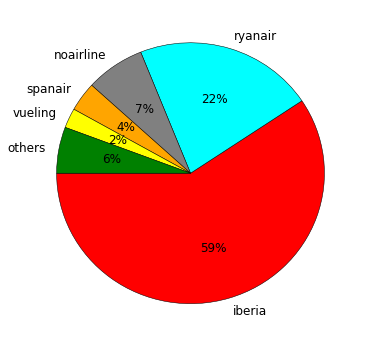

In [144]:
# Plot -pie chart

# Set matplotlib parameters
rcParams['font.size'] = 12.0
matplotlib.rcParams['lines.linewidth'] = 7
matplotlib.rcParams['font.sans-serif'] = "League Gothic"
matplotlib.rcParams['font.family'] = "sans-serif"

# Pie
p, tx, autotexts = plt.pie(newvalors,labels=newetiquetes,colors  = ("red", "cyan", "grey","orange", "yellow", "green"),
        labeldistance=1.1,startangle=180,
        shadow=False,autopct='%.1f%%',
        wedgeprops={"edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid', 'antialiased': True})
# Re-label each pie piece without decimals (sum = 100%)
perp = ['59%','22%','7%','4%','2%','6%']
for i, a in enumerate(autotexts):
    a.set_text("{}".format(perp[i]))


fig = plt.gcf()
fig.set_size_inches(6,6)
fig.savefig('piechartairlines.jpg', bbox_inches='tight',dpi=300)

### Airlines by sentiment

In [145]:
# Concatenate the 1-hot-encoding dataframe : airlines
df_airlines = pd.concat([df1.newairline_sentiment,airlines1hot], axis=1, join_axes=[df1.index])
df_airlines.head()

,newairline_sentiment,aena,aeromar,aeromexico,aireuropa,airnostrum,americanairlines,avianca,blueair,britishairways,...,noairline,norwegian,ryanair,spanair,spiritairlines,tame,vasp,vueling,westjet,wizzair
tweet_id,,,,,,,,,,,,,,,,,,,,,
942743012337123328,positive,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
926857871916183553,positive,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
936979305720090626,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
943983853802328064,negative,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
938207464457211904,negative,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
# Group df_airlines by airline_sentiment 
df_airlines_sentiments = df_airlines.groupby('newairline_sentiment').sum()
# Select online the most popular airlines
crop = df_airlines_sentiments[['spanair','ryanair','vueling','iberia']]
# Transpose (airlines vs. sentiment)
crop = crop.T
# Compute total number of occurences of each airline
crop['total'] = crop.sum(axis=1)
# Divide each column (negative, neutral, positive) by the total number of occurences of each airline
crop_new = crop.loc[:,"negative":"positive"].div(crop["total"], axis=0)*100.
crop_new.head()

newairline_sentiment,negative,neutral,positive
spanair,42.500000,35.000000,22.500000
ryanair,48.688915,32.896305,18.414779
vueling,52.380952,35.978836,11.640212
iberia,53.016772,28.686561,18.296667


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


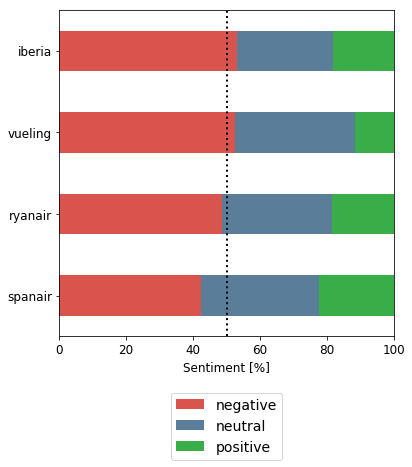

In [147]:
# Plot (bar plot)
my_colors = [sns.xkcd_rgb["pale red"],sns.xkcd_rgb["steel blue"], sns.xkcd_rgb["medium green"]]
ax = crop_new.plot(kind='barh',stacked=True, color=my_colors,figsize=(6,6))
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -0.4),prop={'size': 14})
ax.set_xlim([0,100])
ax.set_xlabel('Sentiment [%]')
plt.axvline(x=50,color='black',linewidth=2,linestyle=':')
plt.savefig("AirlinesBYSentiment.jpg", bbox_inches='tight',dpi=400)
plt.show()